In [1]:
import numpy as np
import pandas as pd
import joblib
import os
import time
import glob
from tqdm import tqdm
import matplotlib

In [2]:
df = pd.read_csv("data/pickles_to_df.csv")

In [3]:
df.head(2)

,id,sku,type,sex,color,breed,feed,age_in_month,slides,sale_offer_percentage,...,price,is_special,is_dewormed,is_fmd_vaccinated,is_anthrax_vaccinated,is_lumpy_skin_disease,size,thumbnail,created_at,status
0,1d9ff108-60dc-4f9e-98b4-e85ced1c6a67,BLF 2340,COW,MALE_BULL,RED,LOCAL,"['JUMBOO', 'LUCERNE', 'NAPIER', 'SILAGE', 'STR...",2 Years,[{'id': '640e1e9e-3f5e-4792-93d2-6a5f53594698'...,0.0,...,19000.0,False,True,True,True,True,MEDIUM,https://uploads-prod.aws.bengalmeat.com/media/...,2021-07-17T20:02:29.885357+06:00,SHARED_ORDERED
1,685f6e3e-2ed6-46ec-9b3c-4c52a7913ed4,BLF 2342,COW,MALE_BULL,NON_RED,LOCAL,"['JUMBOO', 'LUCERNE', 'NAPIER', 'SILAGE', 'STR...",2 Years,[{'id': '4cc01c8c-0fa9-412b-89b4-de611f612b38'...,0.0,...,18000.0,False,True,True,True,True,LARGE,https://uploads-prod.aws.bengalmeat.com/media/...,2021-07-17T20:13:06.519925+06:00,SHARED


In [4]:
df.shape

(514, 26)

In [5]:
columns = ['sku', 'type', 'sex', 'color', 'breed', 'feed', 'age_in_month', 'feedlot_in_month', 'teeth', 'height_in_inch', 'weight_in_kg', 'price', 'size']
df = df.loc[:, columns]

In [6]:
df.head(2)

,sku,type,sex,color,breed,feed,age_in_month,feedlot_in_month,teeth,height_in_inch,weight_in_kg,price,size
0,BLF 2340,COW,MALE_BULL,RED,LOCAL,"['JUMBOO', 'LUCERNE', 'NAPIER', 'SILAGE', 'STR...",2 Years,3 Months,2,50.9,270.0,19000.0,MEDIUM
1,BLF 2342,COW,MALE_BULL,NON_RED,LOCAL,"['JUMBOO', 'LUCERNE', 'NAPIER', 'SILAGE', 'STR...",2 Years,3 Months,2,52.0,256.0,18000.0,LARGE


['MALE_BULL', 'FEMALE_HEIFER']
2


<AxesSubplot:>

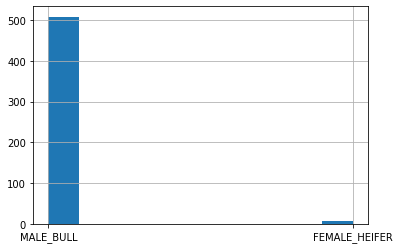

In [7]:
unique_sex = list(df.sex.unique()) # Input
print(unique_sex)
print(len(unique_sex))
df.sex.hist()

[2, 4, 6]
3


<AxesSubplot:>

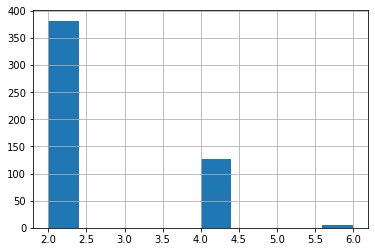

In [8]:
unique_teeth = list(df.teeth.unique()) # Input
print(unique_teeth)
print(len(unique_teeth))
df.teeth.hist()

['LOCAL', 'SAHIWAL', 'RED_CHITTAGONG', 'SINDHI', 'PABNA_BREED', 'HOSTINE_CROSS', 'BRAHMA', 'MIR_KADIM']
8


<AxesSubplot:>

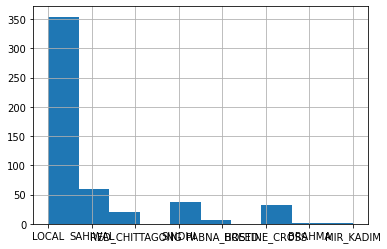

In [9]:
unique_breed = list(df.breed.unique()) # Output
print(unique_breed)
print(len(unique_breed))
df.breed.hist()

['2 Years', '2.5 Years', '3 Years']
3


<AxesSubplot:>

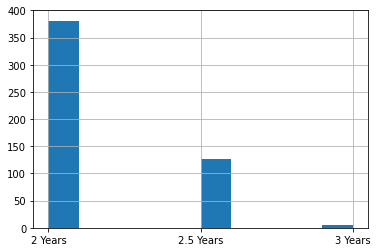

In [10]:
unique_age_in_month = list(df.age_in_month.unique()) # Output
print(unique_age_in_month)
print(len(unique_age_in_month))
df.age_in_month.hist()

[50.9, 52.0, 48.5, 51.0, 44.0, 43.5, 45.0, 48.0, 46.0, 43.2, 47.0, 45.8, 42.0, 44.6, 45.2, 49.0, 46.6, 44.5, 48.7, 47.2, 50.0, 41.0, 45.6, 47.1, 44.3, 43.7, 53.6, 47.5, 50.3, 46.8, 42.9, 46.9, 48.3, 42.6, 43.0, 48.4, 47.3, 45.5, 49.2, 49.8, 49.3, 43.1, 42.4, 49.4, 55.5, 49.6, 45.7, 48.1, 44.8, 45.4, 51.6, 42.2, 40.6, 47.7, 41.5, 44.4, 46.5, 46.3, 47.8, 44.9, 52.8, 51.5, 50.7, 55.0, 50.4, 43.4, 50.5, 45.3, 49.5, 46.2, 47.6, 45.9, 44.2, 41.6, 39.0, 41.4, 45.1, 47.9, 41.2, 42.3, 43.6, 40.0, 57.6, 52.1, 50.8, 51.9, 54.0, 54.9, 57.0, 53.0, 56.4, 50.2, 51.1, 52.5, 56.1, 56.8, 52.3, 42.8, 43.3, 52.4, 44.7, 39.1, 38.0, 38.8, 42.5, 58.2, 51.2]
107


<AxesSubplot:>

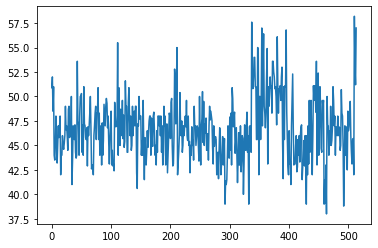

In [11]:
unique_height_in_inch = list(df.height_in_inch.unique()) # Output
print(unique_height_in_inch)
print(len(unique_height_in_inch))
df.height_in_inch.plot()

[270.0, 256.0, 279.0, 296.0, 212.0, 202.0, 205.0, 258.0, 240.0, 215.0, 226.0, 224.0, 245.0, 255.0, 185.0, 200.0, 210.0, 250.0, 211.0, 225.0, 230.0, 265.0, 160.0, 242.0, 235.0, 220.0, 345.0, 282.0, 246.0, 315.0, 285.0, 300.0, 275.0, 216.0, 302.0, 273.0, 218.0, 213.0, 288.0, 267.0, 286.0, 305.0, 227.0, 236.0, 281.0, 272.0, 262.0, 239.0, 280.0, 217.0, 195.0, 223.0, 287.0, 271.0, 263.0, 252.0, 222.0, 221.0, 0.0, 257.0, 295.0, 208.0, 238.0, 179.0, 181.0, 259.0, 277.0, 291.0, 247.0, 283.0, 260.0, 201.0, 234.0, 244.0, 170.0, 249.0, 289.0, 266.0, 199.0, 219.0, 172.0, 204.0, 268.0, 180.0, 232.0, 229.0, 203.0, 241.0, 254.0, 261.0, 269.0, 196.0, 248.0, 209.0, 299.0, 311.0, 189.0, 194.0, 207.0, 214.0, 197.0, 251.0, 228.0, 206.0, 231.0, 183.0, 164.0, 176.0, 174.0, 186.0, 162.0, 154.0, 237.0, 173.0, 264.0, 191.0, 182.0, 161.0, 178.0, 198.0, 150.0, 155.0, 816.0, 606.0, 383.0, 375.0, 430.0, 340.0, 322.0, 243.0, 457.0, 415.0, 278.0, 438.0, 355.0, 330.0, 545.0, 378.0, 407.0, 487.0, 297.0, 276.0, 546.0, 

<AxesSubplot:>

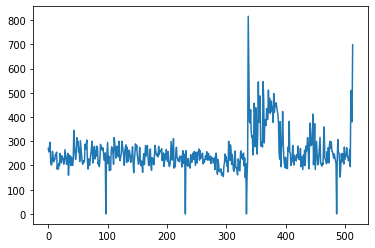

In [12]:
unique_weight_in_kg = list(df.weight_in_kg.unique()) # Output
print(unique_weight_in_kg)
print(len(unique_weight_in_kg))
df.weight_in_kg.plot()

[19000.0, 18000.0, 120000.0, 125000.0, 92000.0, 88000.0, 112000.0, 102000.0, 95000.0, 96000.0, 105000.0, 104000.0, 108000.0, 79000.0, 85000.0, 91000.0, 97000.0, 98000.0, 89000.0, 111000.0, 90000.0, 106000.0, 71000.0, 99000.0, 87000.0, 100000.0, 86000.0, 93000.0, 146000.0, 122000.0, 109000.0, 136000.0, 123000.0, 129000.0, 119000.0, 94000.0, 131000.0, 117000.0, 115000.0, 127000.0, 80000.0, 107000.0, 121000.0, 130000.0, 103000.0, 118000.0, 84000.0, 116000.0, 20000.0, 114000.0, 81000.0, 128000.0, 101000.0, 78000.0, 110000.0, 133000.0, 126000.0, 75000.0, 76000.0, 113000.0, 134000.0, 83000.0, 74000.0, 82000.0, 73000.0, 72000.0, 70000.0, 77000.0, 124000.0, 107930.0, 66000.0, 60000.0, 16000.0, 335000.0, 265000.0, 162000.0, 161000.0, 180000.0, 143000.0, 135000.0, 138000.0, 197000.0, 179000.0, 185000.0, 24000.0, 142000.0, 230000.0, 163000.0, 172000.0, 208000.0, 203000.0, 26000.0, 158000.0, 210000.0, 174000.0, 171000.0, 182000.0, 30000.0, 25000.0, 209000.0, 173000.0, 184000.0, 189000.0, 175000.0,

<AxesSubplot:>

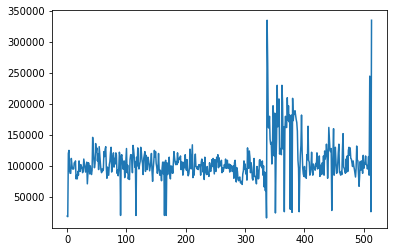

In [13]:
unique_price = list(df.price.unique()) # Output
print(unique_price)
print(len(unique_price))
df.price.plot()

In [14]:
unique_feedlot_in_month = list(df.feedlot_in_month.unique()) # None
print(unique_feedlot_in_month)
print(len(unique_feedlot_in_month))

['3 Months', '3 Years', '24 Months', '12 Months', '6 Months', '4 Months']
6


In [15]:
unique_color = list(df.color.unique()) # None
print(unique_color)
print(len(unique_color))

['RED', 'NON_RED']
2


In [16]:
unique_size = list(df.loc[:, "size"].unique()) # None
print(unique_size)
print(len(unique_size))

['MEDIUM', 'LARGE', 'MINIMUM', 'EXTRA_LARGE', nan]
5


In [17]:
unique_type = list(df.loc[:, "type"].unique()) # None
print(unique_type)
print(len(unique_type))

['COW']
1
